# PyKOALA Data Reduction Sequence (Standard stars)

This notebook contains the basic reduction steps that can be done with pyKOALA for the KOALA instrument.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from koala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")
print("pyKOALA version: ", __version__)

pyKOALA version:  0.4.1+4.g92e4df1.dirty


First, let's import a basic module to handle the RSS data:

In [2]:
from koala.koala_ifu import koala_rss

The koala_rss is a *DataContainer* that will be used to store the RSS data and track all the changes applied to it.

Now let's load some data that we have partially reduced with 2dfdr. The target will be the spectrophotometric standard star HR7596:

In [3]:
# List of RSS objects
std_star_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'red'
path_to_data = 'data'

for i in [28, 29, 30]:
    filename = f"{path_to_data}/27feb{aaomega_arms[arm]}00{i}red.fits"
    rss = koala_rss(filename)
    print(f"File {filename} corresponds to object {rss.header['OBJECT']}")
    std_star_rss.append(rss)

File data/27feb20028red.fits corresponds to object HILT600 A
File data/27feb20029red.fits corresponds to object HILT600 B 3S
File data/27feb20030red.fits corresponds to object HILT600 C 3W


Now let us start applying some corrections to the data!

In this tutorial, we will consider the following corrections:
- Instrumental throughput
- Atmospheric extinction
- Telluric absorption
- Sky emission

Some of these corrections might not be relevant at a particular wavelength regime. For example, the blue arm of the AAOMega spectrograph 3600-5000 A is not affected by the telluric absorption.

# Corrections
## Instrumental throughput

In [4]:
from koala.corrections.throughput import ThroughputCorrection
from koala.plotting.qc_plot import qc_throughput

The throughput correction accounts for the differences in the efficiency of each fibre in the instrument. This effect also depends on the wavelength that we are using.

In pyKOALA (at least version <= 0.1.1) this can be computed from a set of input rss files that correspond to flat exposures as follows

In [5]:
flat_rss = [koala_rss("data/combined_skyflat_red.fits")]
throughput = ThroughputCorrection.create_throughput_from_rss(flat_rss, clear_nan=True)

throughput_corr = ThroughputCorrection(throughput=throughput)
for i in range(len(std_star_rss)):
    std_star_rss[i] = throughput_corr.apply(std_star_rss[i])

Applying nearest neighbour interpolation to remove NaN values


We can assess the quality of our resulting throughput correction by using the built-in quality control plotting functions

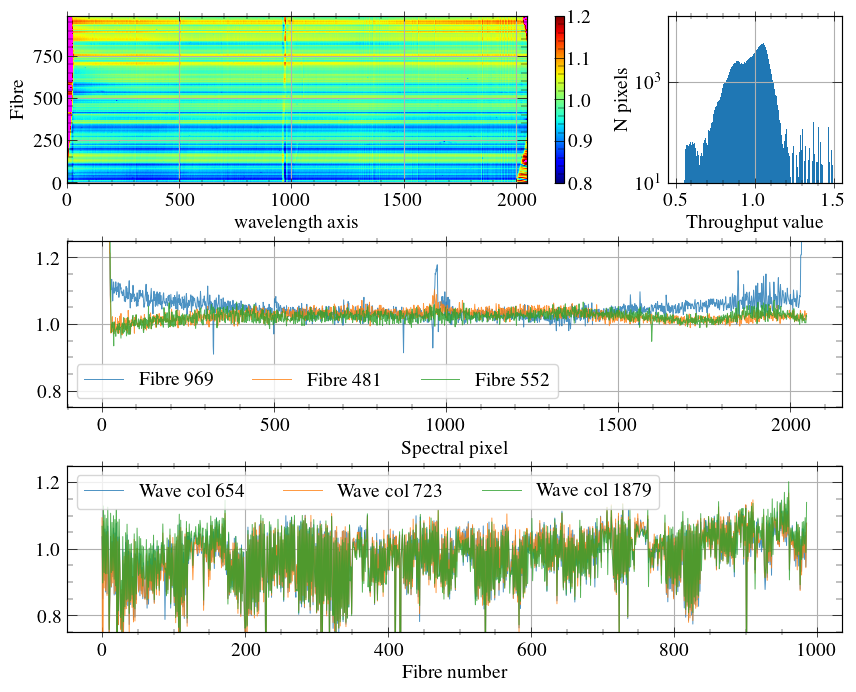

In [6]:
throughput_fig = qc_throughput(throughput)
plt.show(throughput_fig)

Each correction is recorded within the `log` attribute:

In [7]:
for key, val in std_star_rss[0].log.items():
    print(f"Process *{key}* with info:\n   {val}")

Process *read* with info:
   {'comment': '- RSS read from  27feb20028red.fits', 'index': None}
Process *mask from file* with info:
   {'comment': None, 'index': 0}
Process *blue edge* with info:
   {'comment': None, 'index': 1}
Process *red edge* with info:
   {'comment': None, 'index': 2}
Process *cosmic* with info:
   {'comment': None, 'index': 3}
Process *extreme negative* with info:
   {'comment': None, 'index': 4}
Process *wavelength fix* with info:
   {'comment': None, 'index': None, 'sol': []}


## Atmospheric extinction

In [8]:
from koala.corrections.atmospheric_corrections import AtmosphericExtinction

AtmosphericExtinction?

In [9]:
atm_ext_corr = AtmosphericExtinction(verbose=True)

[Correction: AtmosphericExtinction] Initialising Atm ext. correction model.
[Correction: AtmosphericExtinction] Loading atmospheric extinction model from:
 /home/pcorchoc/Develop/koala/src/koala/corrections/../input_data/observatory_extinction/ssoextinct.dat


In [10]:
for i in range(len(std_star_rss)):
    std_star_rss[i] = atm_ext_corr.apply(std_star_rss[i])

[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.23 airmass)
[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.22 airmass)
[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.22 airmass)


## Telluric absorption

In [11]:
from koala.corrections.sky import Tellurics

There are two ways of estimating the Tellucir correction: using a default model or using an empirical approach from the data

[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Applying telluric correction to this star...
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Applying telluric correction to this star...
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Applying telluric correction to this star...


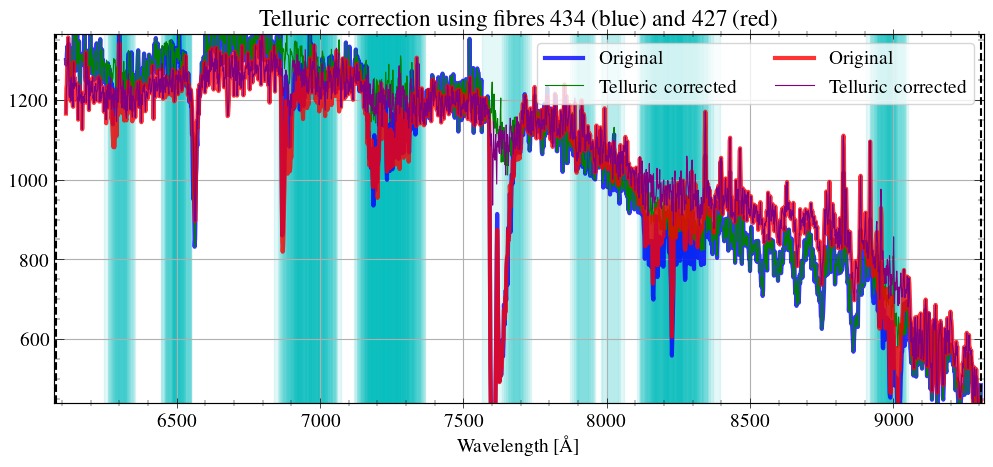

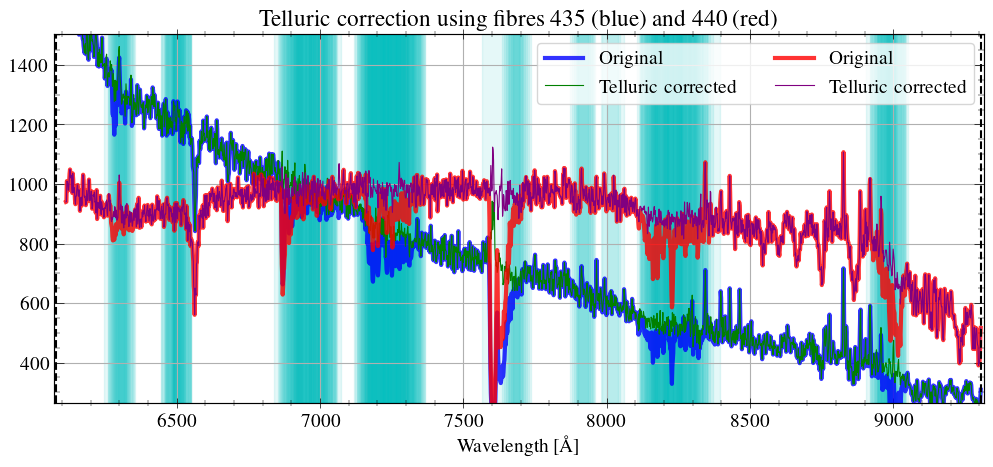

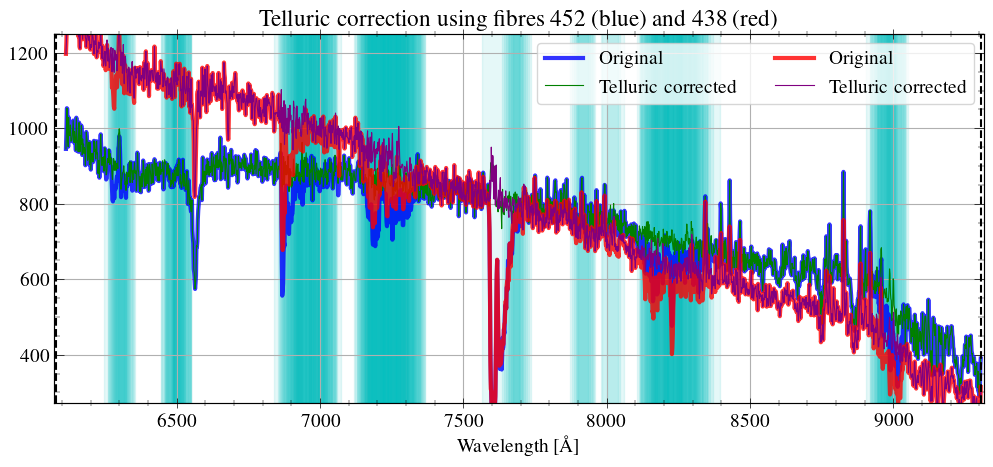

In [12]:
all_telluric_corrections = []
for i in range(len(std_star_rss)):
    telluric_correction = Tellurics(std_star_rss[i], verbose=True)
    _, fig = telluric_correction.telluric_from_model(
                plot=True, width=30)
    # Reopen the figure
    plt.figure(fig)
    
    # Apply the correction to the star
    std_star_rss[i] = telluric_correction.apply(std_star_rss[i])
    all_telluric_corrections.append(telluric_correction.telluric_correction)

We may be interested in storing the resulting telluric function for applying it on other frames.

## Sky emission

This is quite a difficult correction. In particular, KOALA does not count with auxiliary sky fibres that allow to estimate the sky brightness simultaneous to the acquisition of data. Therefore, the estimation of the sky contribution must be inferred from the science exposure or from offset sky frames taken between the observing sequence. 

At present, pyKOALA provides several ways to estimate a sky emission model... See the sky emission tutorial for a more detailed discussion.

In [13]:
from koala.corrections import sky
sky.SkyFromObject?

[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction
[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction
[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction


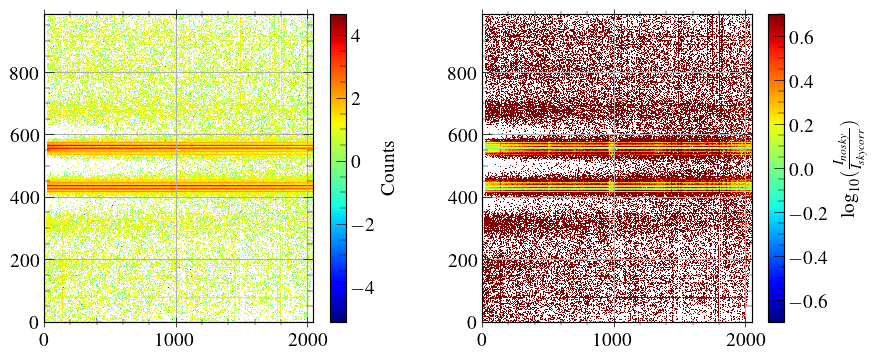

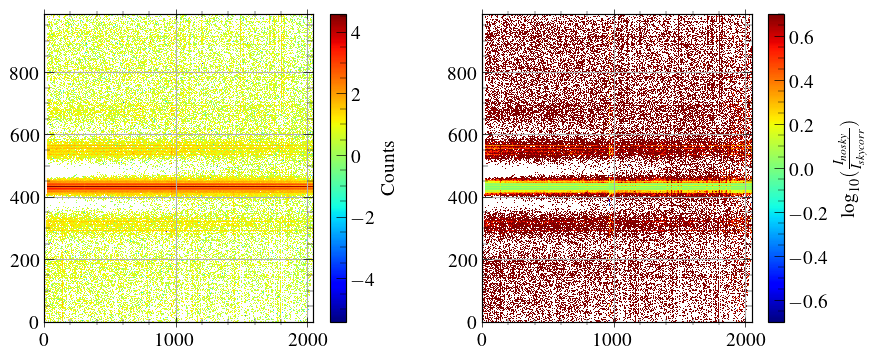

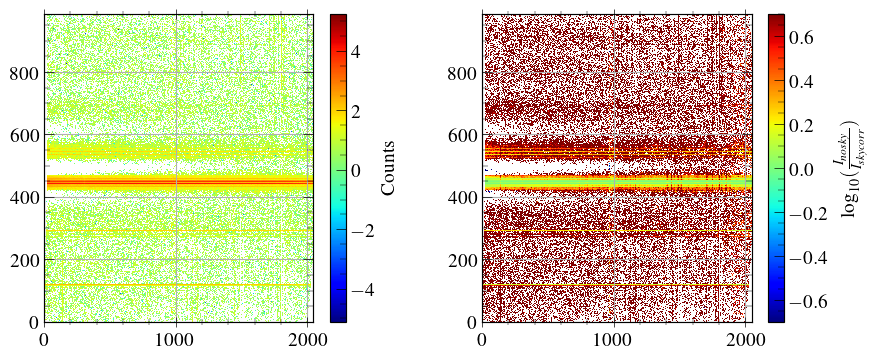

In [14]:
for i in range(len(std_star_rss)):
    skymodel = sky.SkyFromObject(std_star_rss[i], bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
    skycorrection = sky.SkySubsCorrection(skymodel)
    
    # Store the value of the RSS intensity before substraction
    intensity_no_sky = std_star_rss[i].intensity_corrected.copy()

    std_star_rss[i], _ = skycorrection.apply(std_star_rss[i])
    
    # Compare between the two versions of the data
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(121)
    mappable = ax.imshow(np.log10(std_star_rss[i].intensity_corrected),
                         origin='lower', aspect='auto',
                         interpolation='none', cmap='jet')
    plt.colorbar(mappable, ax=ax, label='Counts')
    ax = fig.add_subplot(122)
    mappable = ax.imshow(np.log10(intensity_no_sky / std_star_rss[i].intensity_corrected),
                         vmin=-0.7, vmax=.7, origin='lower', aspect='auto',
                         interpolation='none', cmap='jet')
    plt.colorbar(mappable, ax=ax, label=r'$\log_{10}(\frac{I_{nosky}}{I_{skycorr}})$')
    plt.subplots_adjust(wspace=0.3)


# Cubing

For the final part of this tutorial, now we will see how to combine a set of RSS data into a 3D datacube.

- (optional) The first step would consists of registering the data, i.e., account for the spatial offset between the different frames eigther produced by instrumental innacuracies or due to the application of dithering patterns.
- ADR correction. The data might be affected by atmospheric differential refraction, producing a wavelength-dependent shift of the image.
- Cube interpolation.

## Registration

To register a set of stardad star frames, we will use the function `register_stars`. This function fits a 2D Moffat profile using the data available from each fibre.

[Registering] Registering stars through 2D-Moffat modelling.
Object:  HILT600 A
[Registration] Fitting 2D Moffat profile
[Registration]  Data provided in RSS format --> creating a dummy datacube
[Registration] 2D Moffat Initial guess:  {'amplitude': 154377839.27453533, 'x_0': -0.1893940107503279, 'y_0': -0.42704399966630524, 'gamma': 1.3561323781961228, 'alpha': 1}
[Registration] 2D Moffat fit results:
 -------------------------------------------------- 
 Model: Moffat2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude             x_0                  y_0               gamma              alpha       
    ----------------- -------------------- ------------------- ------------------ ------------------
    4638450.863245326 -0.15619396340899594 -0.5932909195876387 1.1597715056729998 2.3995592788226325 
 -------------------------------------------------- 

[RSS] Offset-coords updated
[RSS] Centre coords (101.3049, 2.1383) updated to (-0.0000, -0.0002)
Obje

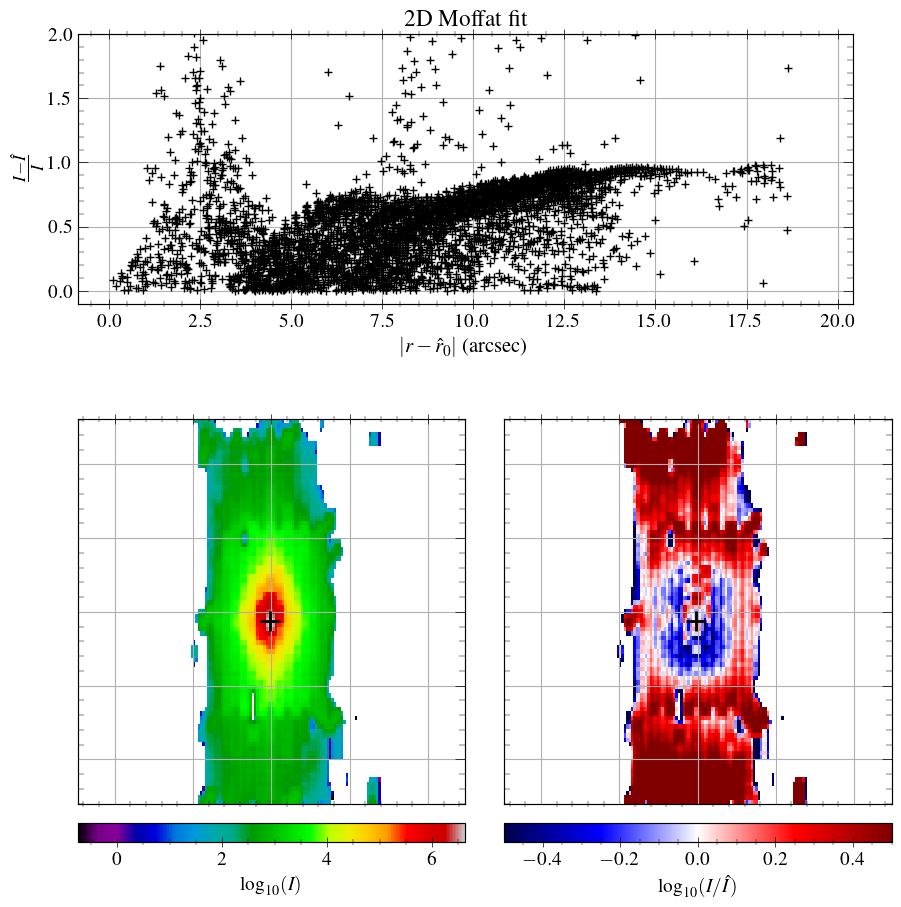

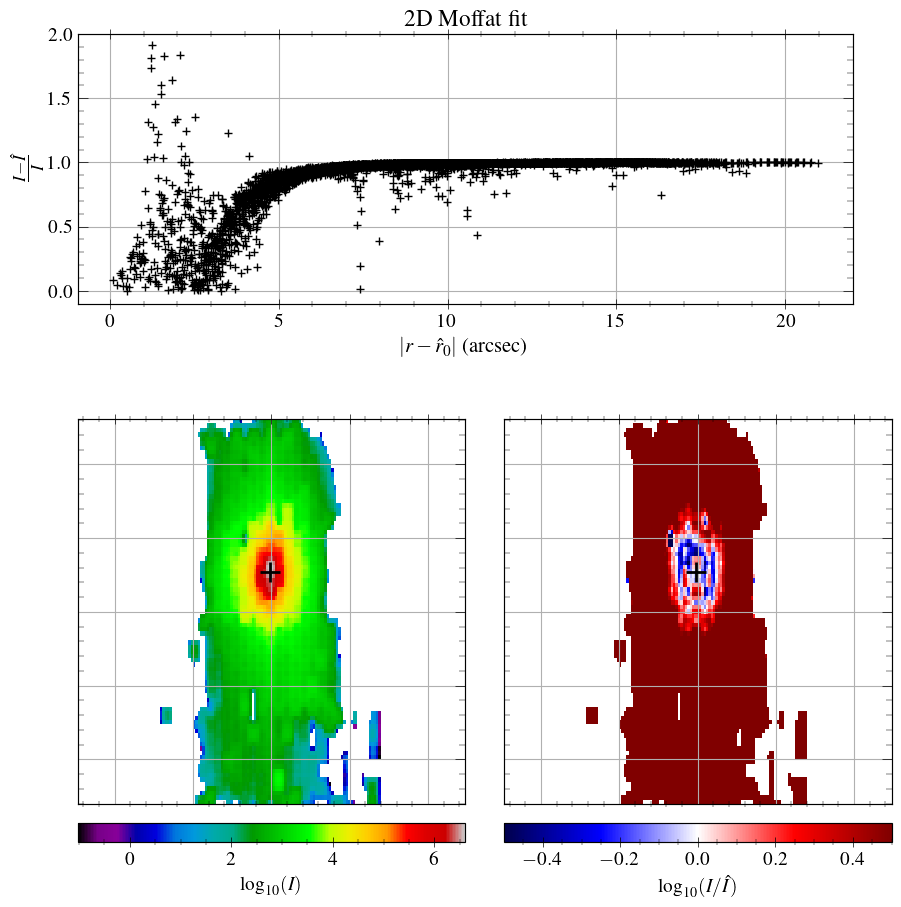

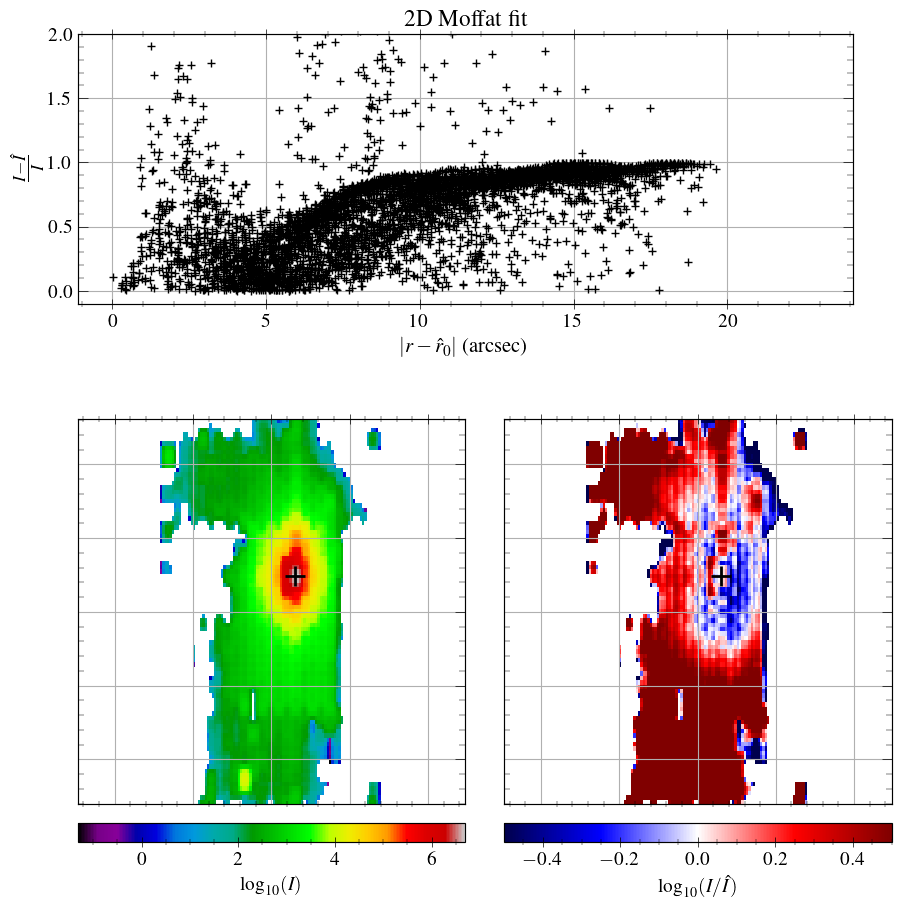

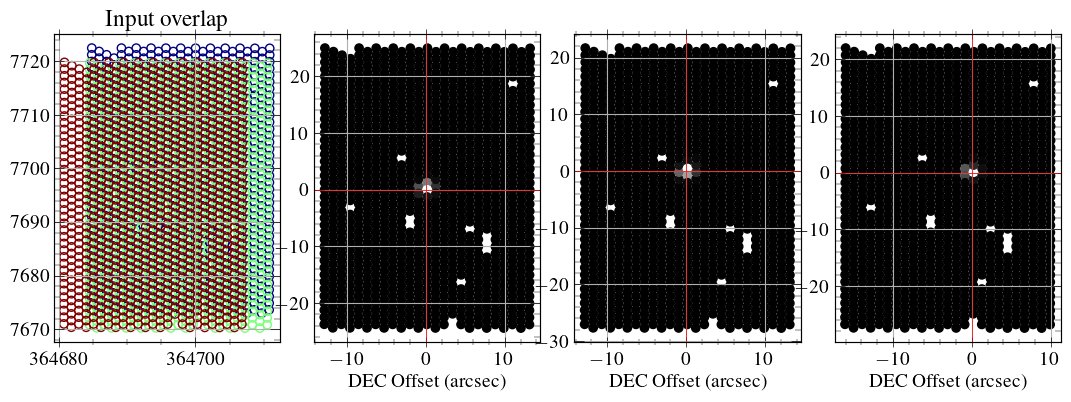

In [15]:
from koala.register.registration import register_stars

fig = register_stars(std_star_rss, moffat=True, plot=True)

## Atmospheric differential refraction

Accounting for this correction is way more easier with standard stars than with extended sources. The idea is to track the centroid of the star as function of wavelength to derive the offsets produced by the ADR.

In [16]:
from koala.corrections.atmospheric_corrections import get_adr

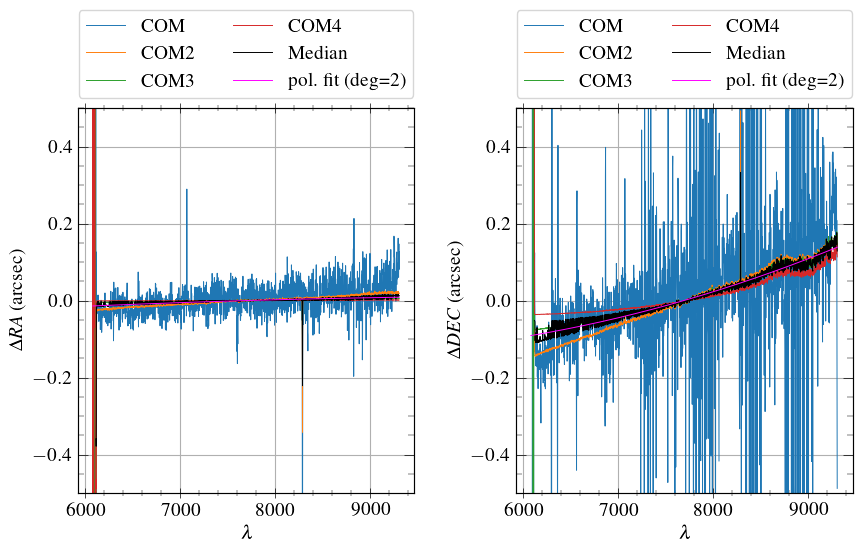

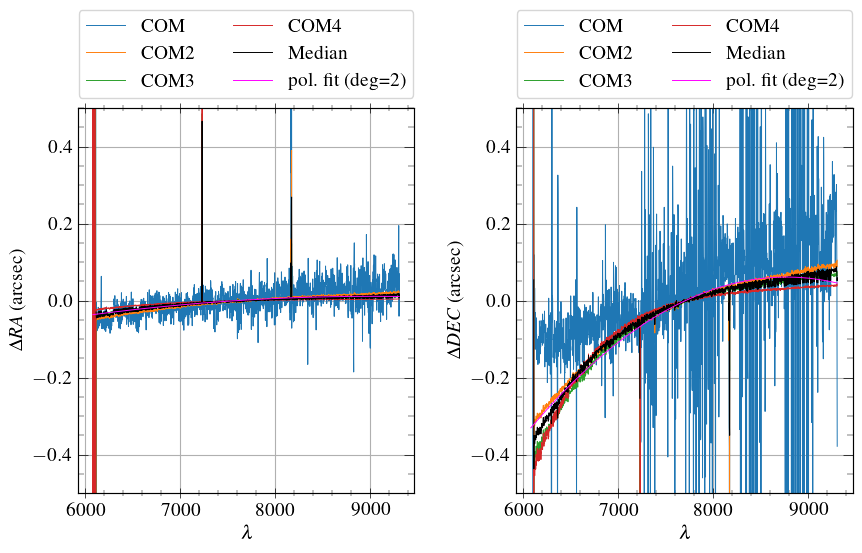

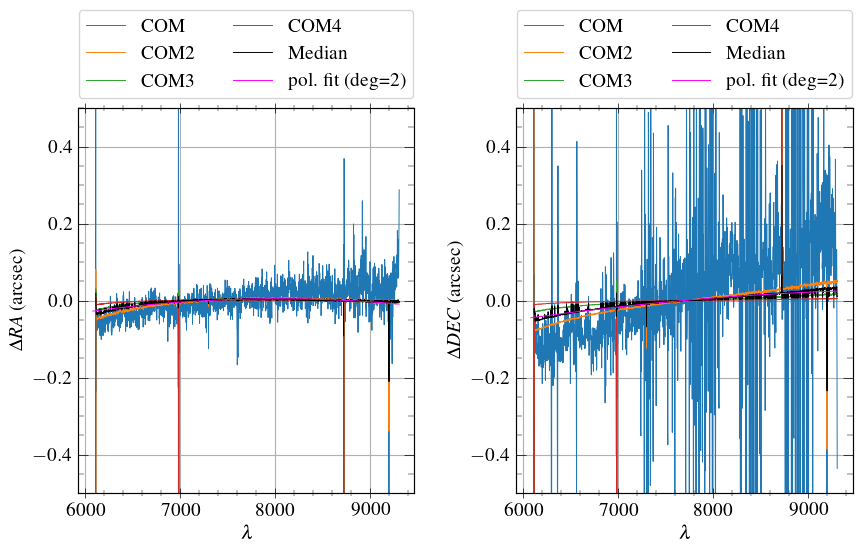

In [17]:
adr_corr_x = []
adr_corr_y = []
for rss in std_star_rss:
    adr_pol_x, adr_pol_y, fig = get_adr(rss, max_adr=0.5, pol_deg=2,
                                        plot=True)
    adr_corr_x.append(adr_pol_x)
    adr_corr_y.append(adr_pol_y)
    
    plt.show(plt.figure(fig))

## RSS cubing

In [18]:
from koala.cubing import build_cube
from koala.plotting.qc_plot import qc_cube

In [19]:
cube = build_cube(rss_set=std_star_rss,
                  reference_coords=(0, 0),
                  reference_pa=0, cube_size_arcsec=(30, 30),
                  pixel_size_arcsec=.2,
                  name="HILT600",
                  adr_x_set=adr_corr_x,
                  adr_y_set=adr_corr_y)

[Cubing] Starting cubing process
[Cubing] 1-th RSS fibre (transformed) offset with respect reference pos:  (0.0, 0.0)  arcsec
[Cubing] 2-th RSS fibre (transformed) offset with respect reference pos:  (0.0, 0.0)  arcsec
[Cubing] 3-th RSS fibre (transformed) offset with respect reference pos:  (0.0, 0.0)  arcsec


In [20]:
fig = qc_cube(cube)

[QCPLOT] Cube QC plot for:  HILT600


# Flux calibration

The final step will consists of deriving the instrumental response function (that would be used to correct the rest of the observed data). Although this is shown for just one star, ideally the final response function that will be used with the science data should be based on several standard stars.

In [21]:
from koala.corrections.flux_calibration import FluxCalibration

response_params = dict(pol_deg=None, gauss_smooth_sigma=100,
                           plot=True)
fcal = FluxCalibration()
results = fcal.auto(data=[cube],
                    calib_stars=[cube.info['name']],
                    fnames=None,
                    save='products',
                    response_params=response_params)

dict_keys(['extraction', 'interp', 'response', 'response_fig'])


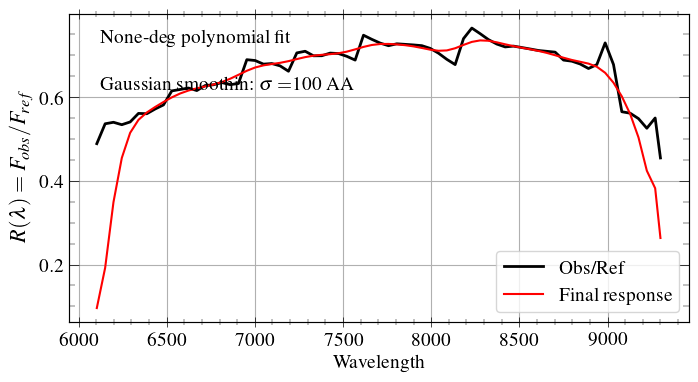

In [22]:
print(results['HILT600'].keys())
results['HILT600']['response_fig']